In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, t
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.signal import butter, filtfilt
import time
import pennylane as qml
from pennylane.templates import AngleEmbedding

SAMPLE_LIMIT = 500
FS = 128

root_path = Path.cwd().parent
data_path = root_path / "data" / "raw"

bands = {
    'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13),
    'beta': (13, 30), 'gamma': (30, 45)
}


def bandpass_filter(signal, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, signal)


def permutation_entropy(time_series, order=3, delay=1):
    n = len(time_series)
    if n < order * delay: return 0
    permutations = np.array([time_series[i:i + order * delay:delay] for i in range(n - (order - 1) * delay)])

    if len(permutations) == 0: return 0

    try:
        sorted_idx = np.argsort(permutations, axis=1)
        patterns, counts = np.unique(sorted_idx, axis=0, return_counts=True)
        probs = counts / counts.sum()
        return -np.sum(probs * np.log2(probs + 1e-10))
    except:
        return 0


def spike_detection(signal, threshold=3):
    if np.std(signal) == 0: return 0
    spikes = np.where(np.abs(signal - np.mean(signal)) > threshold * np.std(signal))[0]
    return len(spikes)


def band_features(signal, fs):
    de_sq_list = []
    spike_list = []
    for band_name in bands:
        lowcut, highcut = bands[band_name]
        try:
            filtered = bandpass_filter(signal, fs, lowcut, highcut)
            variance = np.var(filtered)
            if variance <= 0: variance = 1e-10
            de = 0.5 * np.log(2 * np.pi * np.e * variance)
            de_sq_list.append(de ** 2)
            spike_list.append(spike_detection(filtered))
        except:
            de_sq_list.append(0);
            spike_list.append(0)

    try:
        delta_filtered = bandpass_filter(signal, fs, 0.5, 4)
        pe_delta = permutation_entropy(delta_filtered)
    except:
        pe_delta = 0

    return de_sq_list + spike_list + [pe_delta]


def process_window(start, eeg_values, window_size_samples, fs):
    window = eeg_values[start:start + window_size_samples]
    if len(window) < window_size_samples: return None
    if np.all(window == 0): return None
    return band_features(window, fs)


def trim_zero_ends(eeg, bis, fs_eeg=128, fs_bis=1):
    bis = np.array(bis)
    eeg = np.array(eeg)
    bis_start_idx = next((i for i, val in enumerate(bis) if val != 0), None)
    bis_end_idx = next((i for i, val in enumerate(bis[::-1]) if val != 0), None)
    if bis_start_idx is None or bis_end_idx is None:
        return np.array([]), np.array([])
    bis_end_idx = len(bis) - bis_end_idx

    start_time = bis_start_idx / fs_bis
    end_time = bis_end_idx / fs_bis
    start_eeg_idx = int(start_time * fs_eeg)
    end_eeg_idx = int(end_time * fs_eeg)

    return eeg[start_eeg_idx:end_eeg_idx], bis[bis_start_idx:bis_end_idx]


n_qubits = 11
dev_kernel = qml.device("lightning.qubit", wires=n_qubits)


@qml.qnode(dev_kernel)
def kernel(x1, x2):
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.probs(wires=range(n_qubits))


def compute_kernel_matrix(X_A, X_B):
    n_A, n_B = len(X_A), len(X_B)
    matrix = np.zeros((n_A, n_B))

    print(f"   Computing Quantum Kernel ({n_A} x {n_B})...")

    start_t = time.time()
    for i in range(n_A):
        for j in range(n_B):
            matrix[i, j] = kernel(X_A[i], X_B[j])[0]

        if (i + 1) % 10 == 0:
            elapsed = time.time() - start_t
            rate = (i + 1) / elapsed
            remaining = (n_A - (i + 1)) / rate
            print(f"   Row {i + 1}/{n_A} | Rate: {rate:.1f} rows/s | ETA: {remaining:.0f}s", end='\r')

    print(f"\n   Done.")
    return matrix


def experiment(SAMPLE_LIMIT):
    window_size_seconds = 56
    step_size_seconds = 1
    advance_seconds = 60

    print("1. Loading Patient 48 Data...")
    try:
        df_eeg = pd.read_csv(data_path / 'patient48_eeg.csv')
        df_bis = pd.read_csv(data_path / 'patient48_bis.csv')
        eeg_raw = df_eeg['EEG'].interpolate('linear').values.flatten()
        bis_raw = df_bis['BIS'].interpolate('linear').values.flatten()
    except Exception as e:
        print(f"Error loading data: {e}");
        exit()

    print("2. Aligning and Trimming...")
    eeg, bis = trim_zero_ends(eeg_raw, bis_raw, fs_eeg=FS, fs_bis=1)

    print(f"3. Extracting Features (Parallel)...")
    win_samples = int(window_size_seconds * FS)
    step_samples = int(step_size_seconds * FS)
    starts = range(0, len(eeg) - win_samples + 1, step_samples)

    features_raw = Parallel(n_jobs=-1)(
        delayed(process_window)(s, eeg, win_samples, FS) for s in starts
    )
    X = np.array([f for f in features_raw if f is not None])

    advance_steps = int(advance_seconds / step_size_seconds)
    y = bis[advance_steps:]
    min_len = min(len(X), len(y))
    X = X[:min_len];
    y = y[:min_len]

    if SAMPLE_LIMIT and len(X) > SAMPLE_LIMIT:
        print(f"   [INFO] Subsampling to {SAMPLE_LIMIT} samples.")
        indices = np.linspace(0, len(X) - 1, SAMPLE_LIMIT).astype(int)
        X = X[indices];
        y = y[indices]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )

    print("4. Scaling (MinMaxScaler 0-PI)...")
    scaler = MinMaxScaler(feature_range=(0, np.pi)).fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("5. Computing Quantum Kernels...")
    t0 = time.time()

    K_train = compute_kernel_matrix(X_train_scaled, X_train_scaled)
    K_test = compute_kernel_matrix(X_test_scaled, X_train_scaled)

    print(f"   -> Kernel Done in {time.time() - t0:.1f}s")

    print("6. Training SVR...")
    model = SVR(kernel='precomputed', C=20.0, epsilon=0.1)
    model.fit(K_train, y_train)

    print("7. Evaluating...")
    y_pred = model.predict(K_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    r, _ = pearsonr(y_test, y_pred)

    coeffs = np.polyfit(y_pred, y_test, 1);
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(y_pred), max(y_pred), 100);
    y_fit = poly(x_fit)

    n = len(y_pred)
    residuals = y_test - poly(y_pred)
    std_err = np.std(residuals)
    t_val = t.ppf(0.975, df=n - 2)
    ci_band = t_val * std_err * np.sqrt(
        1 / n + (x_fit - np.mean(y_pred)) ** 2 / np.sum((y_pred - np.mean(y_pred)) ** 2))
    overall_ci = 1.96 * np.std(y_pred - y_test) / np.sqrt(n)

    print(f"\n--- QUANTUM RESULTS (N={len(X)}) ---")
    print(f"MSE     : {mse:.5f}")
    print(f"RMSE    : {rmse:.5f}")
    print(f"R2      : {r2:.5f}")
    print(f"R       : {r:.5f}")
    print(f"95% CI  : {overall_ci:.5f}")

    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='Actual BIS', alpha=0.7, linewidth=1.5)
    plt.plot(y_pred, label='Quantum Prediction', linestyle='--', linewidth=1.5)
    plt.legend()
    plt.title(f"Quantum SVR Performance\nRMSE={rmse:.2f} | R2={r2:.2f}")
    plt.xlabel("Sample Index")
    plt.ylabel("BIS Value")
    plt.grid(alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_test, label='Predictions', alpha=0.5, color='teal')
    plt.plot(x_fit, y_fit, color='black', label=f'Fit Line (R={r:.2f})')
    plt.fill_between(x_fit, y_fit - ci_band, y_fit + ci_band, color='gray', alpha=0.2, label='95% CI')
    plt.xlabel("Predicted BIS")
    plt.ylabel("Actual BIS")
    plt.title('Correlation Analysis')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

1. Loading Patient 48 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   [INFO] Subsampling to 200 samples.
4. Scaling (MinMaxScaler 0-PI)...
5. Computing Quantum Kernels...
   Computing Quantum Kernel (160 x 160)...
   Row 160/160 | Rate: 2.8 rows/s | ETA: 0s
   Done.
   Computing Quantum Kernel (40 x 160)...
   Row 40/40 | Rate: 2.9 rows/s | ETA: 0s
   Done.
   -> Kernel Done in 71.4s
6. Training SVR...
7. Evaluating...

--- QUANTUM RESULTS (N=200) ---
MSE     : 49.42069
RMSE    : 7.02999
R2      : 0.80768
R       : 0.90388
95% CI  : 2.15208


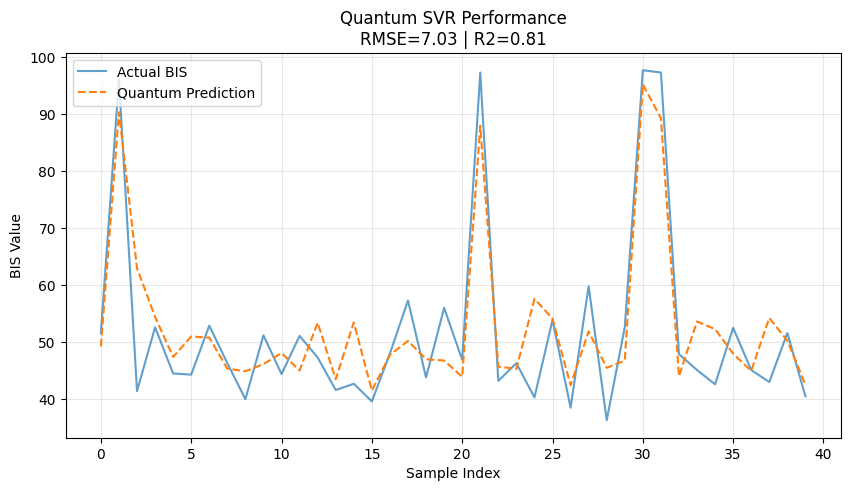

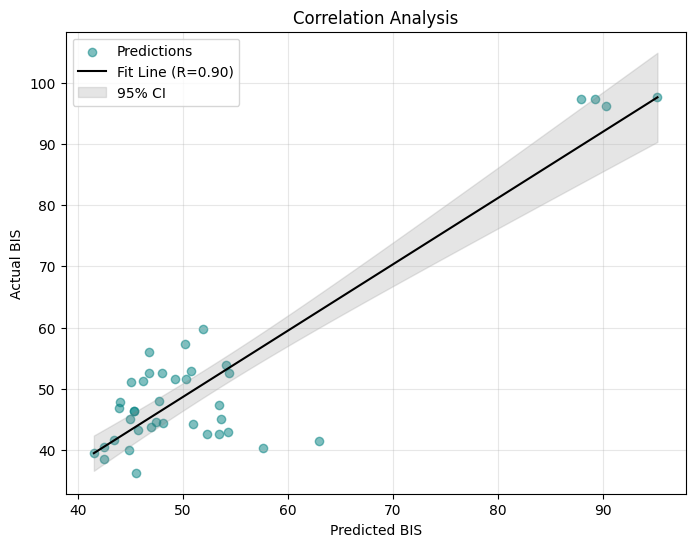

In [20]:
experiment(200)

1. Loading Patient 48 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   [INFO] Subsampling to 500 samples.
4. Scaling (MinMaxScaler 0-PI)...
5. Computing Quantum Kernels...
   Computing Quantum Kernel (400 x 400)...
   Row 400/400 | Rate: 1.2 rows/s | ETA: 0s
   Done.
   Computing Quantum Kernel (100 x 400)...
   Row 100/100 | Rate: 1.2 rows/s | ETA: 0s
   Done.
   -> Kernel Done in 417.8s
6. Training SVR...
7. Evaluating...

--- QUANTUM RESULTS (N=500) ---
MSE     : 36.90098
RMSE    : 6.07462
R2      : 0.86720
R       : 0.93137
95% CI  : 1.18950


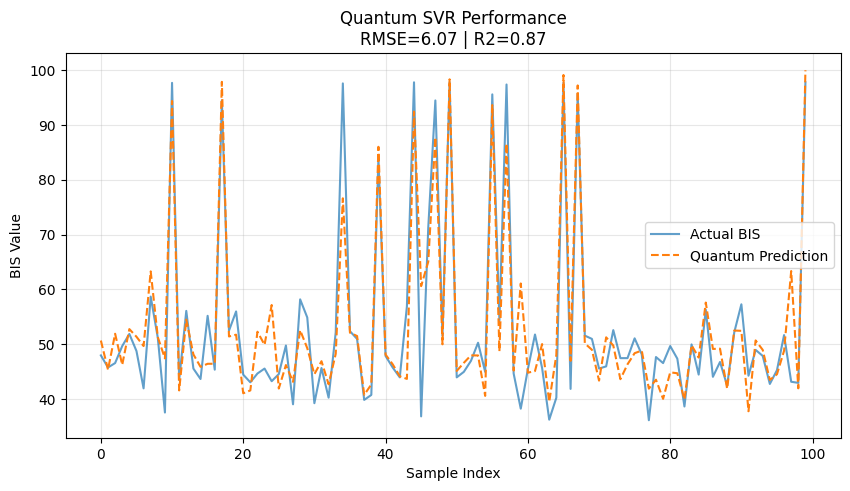

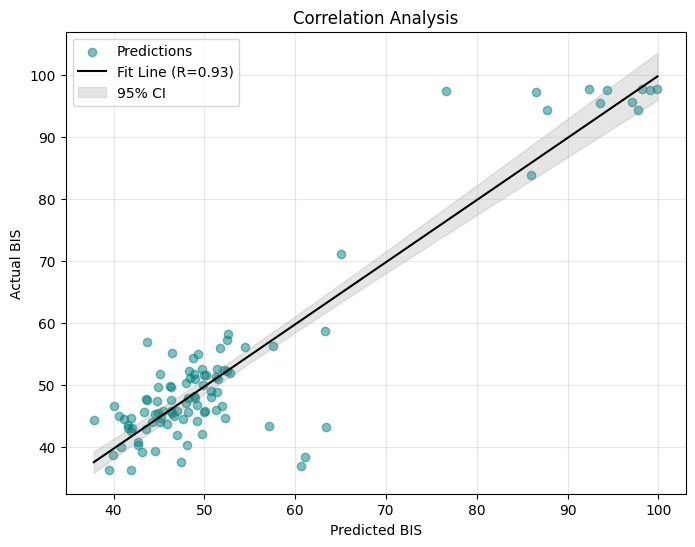

In [21]:
experiment(500)

1. Loading Patient 48 Data...
2. Aligning and Trimming...
3. Extracting Features (Parallel)...
   [INFO] Subsampling to 1000 samples.
4. Scaling (MinMaxScaler 0-PI)...
5. Computing Quantum Kernels...
   Computing Quantum Kernel (800 x 800)...
   Row 800/800 | Rate: 0.7 rows/s | ETA: 0ss
   Done.
   Computing Quantum Kernel (200 x 800)...
   Row 200/200 | Rate: 0.7 rows/s | ETA: 0ss
   Done.
   -> Kernel Done in 1381.2s
6. Training SVR...
7. Evaluating...

--- QUANTUM RESULTS (N=1000) ---
MSE     : 12.44195
RMSE    : 3.52731
R2      : 0.95361
R       : 0.97664
95% CI  : 0.48819


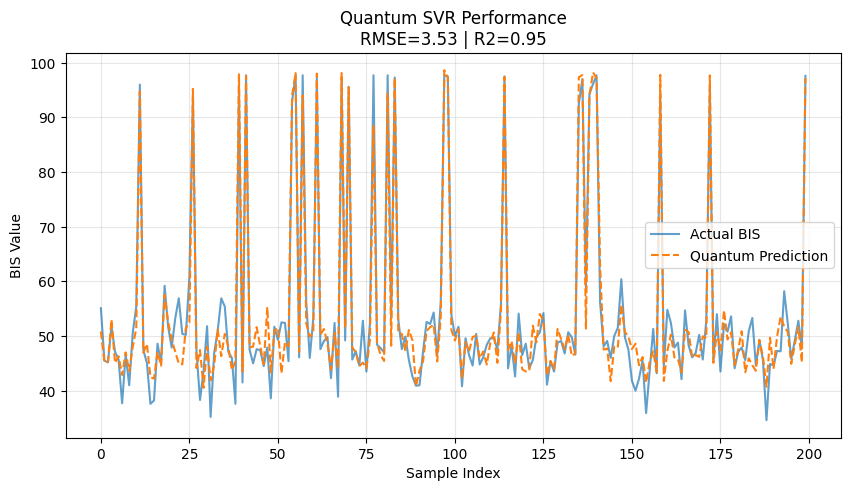

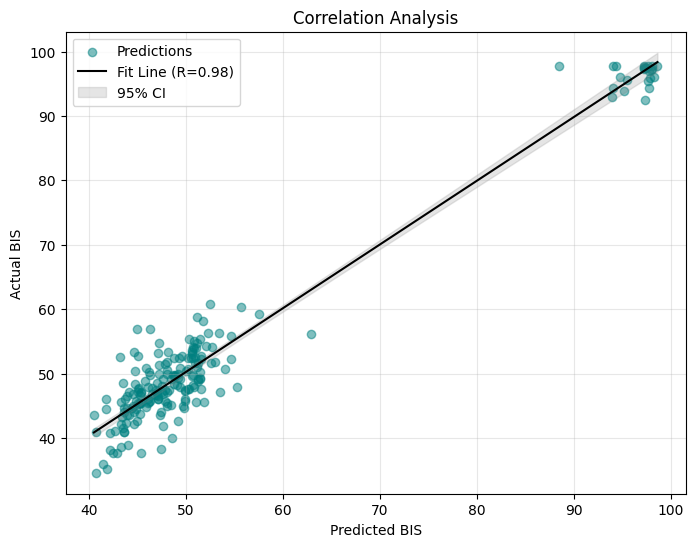

In [22]:
experiment(1000)